# House Price Indices and Hedonic Regression
Anyone living in the UK will be aware of how intwined the performance of its housing market and general economy are. With a limited supply of land being built on and a relatviely high population density, the use of property as a captial asset is common.

Therefore a means to measure the markets performance is of great interest to both investors and lenders whose business is dependent on it. Typically this is provided in the form of a house price index, which aims to provide a relative measure of the value of property overtime. This notebook will attempt to describe how house price indices are derived and used.

In [1]:
%%html
<img src="https://ichef.bbci.co.uk/news/624/cpsprodpb/10F46/production/_95964496_chart_uk_house_prices_april.png", width=500>

## 1. Our Data

The source of data for this project is the "price paid" dataset provided by the ONS (Office for national statistics). This data details the price paid for every property transaction that occured in England and Wales back to April 1995.

Some geospatial public data has also been usecd for this project. 

__Links to the data__:

1 - https://www.gov.uk/government/statistical-data-sets/price-paid-data-downloads

2 -https://data.gov.uk/dataset/7ec10db7-c8f4-4a40-8d82-8921935b4865/national-statistics-postcode-lookup-uk

A snapshot of the data is provided at the end of the code below...

In [1]:
#Importing Packages
import numpy as np
import pandas as pd
import os
import pickle
import time
import matplotlib.cm
import matplotlib.pyplot as plt

In [2]:
data_path = os.path.join(os.getcwd(),'0. Data\\')

In [3]:
def load_data(save=False):
    '''
    --- DATASET INFO ---
    ID                643193 non-null int64
    Price_Paid        643193 non-null int64
    Date              643193 non-null object
    Post_code         639255 non-null object
    Property_Type     643193 non-null object
    New_build         643193 non-null object
    Estate_type       643193 non-null object
    Building_Name     643193 non-null object
    Building_Name2    83519 non-null object
    Street_Name       630497 non-null object
    Locality          237963 non-null object
    Town              643193 non-null object
    District          643193 non-null object
    County            643193 non-null object
    Unknown           643193 non-null object
    Unknown2          643193 non-null object

    Data item     Explanation (where appropriate)
    Transaction unique identifier     A reference number which is generated automatically recording each published sale.
    The number is unique and will change each time a sale is recorded.
    Price     Sale price stated on the transfer deed.
    Date of Transfer     Date when the sale was completed, as stated on the transfer deed.
    Postcode     This is the postcode used at the time of the original transaction. Note that postcodes can be reallocated
    and these changes are not reflected in the Price Paid Dataset.
    Property Type     D = Detached, S = Semi-Detached, T = Terraced, F = Flats/Maisonettes, O = Other
    Note that:
    - we only record the above categories to describe property type, we do not separately identify bungalows.
    - end-of-terrace properties are included in the Terraced category above.
    - ‘Other’ is only valid where the transaction relates to a property type that is not covered by existing values.
    Old/New     Indicates the age of the property and applies to all price paid transactions, residential and non-residential.
    Y = a newly built property, N = an established residential building
    Duration     Relates to the tenure: F = Freehold, L= Leasehold etc.
    Note that HM Land Registry does not record leases of 7 years or less in the Price Paid Dataset.
    PAON     Primary Addressable Object Name. Typically the house number or name.
    SAON     Secondary Addressable Object Name. Where a property has been divided into separate units (for example, flats),
    the PAON (above) will identify the building and a SAON will be specified that identifies the separate unit/flat.
    Street      
    Locality      
    Town/City      
    District      
    County      
    PPD Category Type     Indicates the type of Price Paid transaction.
    A = Standard Price Paid entry, includes single residential property sold for full market value.
    B = Additional Price Paid entry including transfers under a power of sale/repossessions, buy-to-lets (where they can be
     identified by a Mortgage) and transfers to non-private individuals.

    Note that category B does not separately identify the transaction types stated.
    HM Land Registry has been collecting information on Category A transactions from January 1995. Category B transactions
    were identified from October 2013.
    Record Status - monthly file only     Indicates additions, changes and deletions to the records.(see guide below).
    A = Addition
    C = Change
    D = Delete.

    Note that where a transaction changes category type due to misallocation (as above) it will be deleted from the original
    category type and added to the correct category with a new transaction unique identifier.
    '''
    
    t0 = time.time()
    
    df = pd.read_csv(os.path.join(data_path,'pp_complete.csv'),
                     names=['Trans_id', 'price', 'date', 'postcode', 'Property', 'Age','Duration',
                            'PAON', 'SOAN', 'Street', 'Locality', 'Town', 'District', 'County',
                            'PPD', 'Rec_Status'])

    # Converting Date to datetime format
    df['Sale_date'] = pd.to_datetime(df['date'], format='%Y/%m/%d %H:%M')
    df['Sale_quarter'] = df.Sale_date.dt.to_period('Q')

    df['Postcode'] = df.postcode.replace(" ", "",regex=True).str.upper()
    df['Postcode_Dstr'] = df.Postcode.str[:-3]
    df['Postcode_Area'] = df.Postcode_Dstr.str.extract('([A-Z]*)', expand=False)

    # Concatenating all address fields together
    df['Address'] = (df.PAON.replace(np.nan,'', regex=True)
                     + " " + df['SOAN'].replace(np.nan,'', regex=True)
                     + " " + df['Street'].replace(np.nan,'', regex=True)
                     + " " +  df['Postcode'].replace(np.nan,'', regex=True)).replace(' ','', regex=True).str.upper()

    df.price = df.price.astype('int32')

    #Removing properties which didn't sell for their full market value
    df = df[df['PPD']=='A']

    #Remapping some columns
    property_map = {'F':'Flat',
                    'S':'Semi_Detached',
                    'D':'Detached',
                    'O':'Other',
                    'T':'Terraced'}
    age_map = {'N':'Old','Y':'New'}
    Duration_map = {'F':'Freehold','L':'Leasehold','U':'Undeclared'}

    df['Property'] = df['Property'].map(property_map)
    df['Age'] = df['Age'].map(age_map)
    df['Duration'] = df['Duration'].map(Duration_map)

    df = df[['price','Property','Age','Duration','Sale_quarter',
             'Postcode','Postcode_Dstr','Postcode_Area','Address']]

    #Reading in National Statistics Postcode Lookup UK data
    df_pstcde  =  pd.read_csv(os.path.join(os.getcwd(),
                                           '0. Data/National_Statistics_Postcode_Lookup_UK.csv'),header=0)

    df_pstcde = df_pstcde[['Postcode 1','Easting',
                           'Northing','Output Area Classification Name','Region Name','Longitude','Latitude']]

    df_pstcde['Postcode'] = df_pstcde['Postcode 1'].replace(' ','',regex=True).str.upper()
    df_pstcde['Output Area Classification Name'] = df_pstcde['Output Area Classification Name'].str.split(";").str[0]

    df_pstcde = df_pstcde[['Postcode','Easting','Northing','Output Area Classification Name',
                           'Region Name','Longitude','Latitude']]

    pre_merge_vol = df.shape[0]
    df2 = df.merge(df_pstcde,how='inner',on='Postcode')
    if pre_merge_vol>0:
        print("Merging done. {0:.0%} rows lost from ONS data".format( pre_merge_vol/df2.shape[0] -1  ))

    #Sorting data before saving down
    df2_sorted = df2.sort_values(by=['Address','Sale_quarter']).drop_duplicates(subset=['Address','Sale_quarter'])

    t = time.time()-t0
    print("Processing Time:{:}, df shape:{}".format(time.strftime('%H:%M:%S', time.gmtime(t)),df2_sorted.shape))
    
    if save==True:
        df2_sorted.to_pickle(os.path.join(os.getcwd(),'0. Data/Source_0.pkl'))

        df2_lite = df2_sorted[:100000]
        df2_lite.to_pickle(os.path.join(os.getcwd(),'0. Data/Source_0_lite.pkl'))

        #df2_sampled = df2.sample(frac=0.1)
        #df2_sampled.to_csv(os.path.join(os.getcwd(),'0. Data/Source_0_sampled.csv'), index=False)
    
    return df2_sorted

df = load_data(save=True)

Merging done. 0% rows lost from ONS data
Processing Time:00:30:10, df shape:(22875311, 15)


## 2. Creating an Index
### 2.1 Why can't we just take the average price paid?
Now that we've processed our data lets actually do some analysis. 

When producing an index we are trying to produce a single time series index which provides a relative measure of the value of property in the UK overtime.

By observing the price paid for properties that have sold in a given period we estimate the value of property. To create a UK wide index we could simply take the average price paid for property through time and normalise to a selected baseline period, as shown in the figure below. Though this index may be fine, a degree of error will be present due to the fact that we can only measure the value of properties which __have__ sold - thus we are getting a biased measurement. Another way of describing this would be to say that sales occuring in winter consist moreso of flats. Given that flats are generally of lower value than houses, this may give the illusion that house prices are decreasing, when in fact the value of both houses and flats are increasing. Thus we  must be careful in how we perform our measurement.

In [3]:
#reloading data
df = pd.read_pickle(os.path.join(os.getcwd(),'0. Data/Source_0.pkl'))
df.shape

(22875311, 15)

In [4]:
df.head()

,price,Property,Age,Duration,Sale_quarter,Postcode,Postcode_Dstr,Postcode_Area,Address,Easting,Northing,Output Area Classification Name,Region Name,Longitude,Latitude
19170764,89000,Terraced,Old,Freehold,2003Q4,LA95AP,LA9,LA,"''NUTSHELLCOTTAGE,72KIRKLANDLA95AP",351615,492059,Constrained city dwellers,North West,-2.745381,54.321804
10113862,790000,Detached,Old,Freehold,2012Q3,RG53DD,RG5,RG,'FARRIERS'FARRIERSCLOSERG53DD,476083,173528,Suburbanites,South East,-0.906375,51.455629
17093218,305000,Detached,Old,Freehold,2009Q4,WV50AA,WV5,WV,"'HOLMCROFT',40BRIDGNORTHROADWV50AA",386647,291891,Suburbanites,West Midlands,-2.198241,52.524727
7685901,118000,Terraced,Old,Freehold,2010Q4,YO613AE,YO61,YO,(AKERS)CHAPELSTREETYO613AE,452883,469681,Urbanites,Yorkshire and The Humber,-1.192412,54.120283
18877080,251000,Semi_Detached,Old,Freehold,2018Q3,S339GZ,S33,S,(ANDREW)THEHILLSS339GZ,417520,380806,Rural residents,East Midlands,-1.738434,53.323890


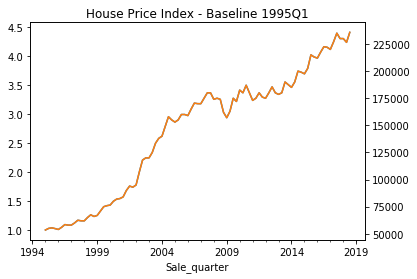

In [5]:
median_price = df.groupby(['Sale_quarter'])['price'].median().to_frame()
median_price['Average Index'] = median_price /median_price.loc[pd.Period('1995Q1',freq='Q')]
median_price['Average Index'].plot()
median_price['price'].plot(secondary_y=True)
plt.title("House Price Index - Baseline 1995Q1")
plt.show()

Plotting the median house price geographically by postcode sector in the figure below, we can see there's a lot of variance in average property prices geographically. Once again this highlights that we must be careful how we make our measurements, as the our sample if far from homogenous. This is where hedonic regression comes in...

In [18]:
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
from matplotlib import style

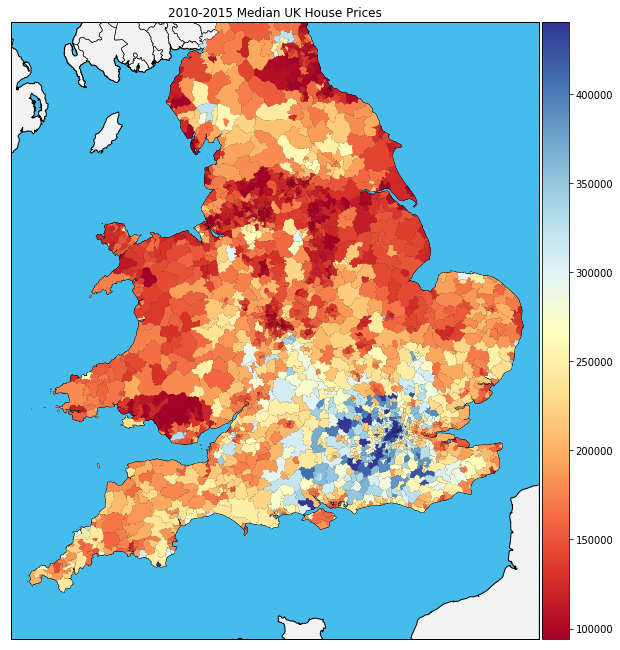

In [18]:
#Plotting median price paid by postcode district
def plot_map(data, title):
    
    df2 = data.loc[(data['Sale_quarter'] > pd.Period('2010-01', freq="Q")) & (data['Sale_quarter'] <= pd.Period('2015-06', freq="Q"))]
    m_price = df2.groupby(['Postcode_Dstr'])['price'].median().to_frame()
    m_price.reset_index(inplace=True)
    
    fig, ax = plt.subplots(figsize=(10,20))
    
    m = Basemap(resolution='h',projection='merc',
                lat_0=54.5,lon_0=-4.36,llcrnrlon=-6.0,
                llcrnrlat=49.5,urcrnrlon=2.,urcrnrlat=55.2)
    
    m.drawmapboundary(fill_color='#46bcec')
    m.fillcontinents(color='#f2f2f2', lake_color='#46bcec')
    m.drawcoastlines()
    
    # Read in shapes and median price into a DataFrame
    m.readshapefile(os.path.join(os.getcwd(),"98. Basemap Resources/Districts"), name='Districts')
    Postcode_Districts = pd.DataFrame({'shapes':[Polygon(np.array(shape),True) for shape in m.Districts],
                                      'Postcode_Dstr':[district['name'] for district in m.Districts_info]})
    Map_df = pd.merge(Postcode_Districts, m_price, how='inner', on='Postcode_Dstr')
    
    # Creating colourmap dictionary
    cmap = plt.cm.RdYlBu
    norm = plt.Normalize(Map_df['price'].quantile(q=0.05),Map_df['price'].quantile(q=0.95))
    pc = PatchCollection(Map_df.shapes,zorder=2)
    
    pc.set_facecolor(cmap(norm(Map_df['price'].fillna(Map_df['price'].min()).values)))
    ax.add_collection(pc)
    #fig.title(title)
    
    #colour bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(Map_df.price)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(sm, cax=cax)
    ax.set_title(title)
    
    plt.show()
    
plot_map(data=df, title="2010-2015 Median UK House Prices")

## 3. Hedonic Regression and House Price Indices
Often when the performance of the housing market is discussed in media you'll see House Price indices such as the Halifax House price index, or Nationwide index being quoted.

Both these indices aim to resolve the issue dicussed above, either through stratification (Nationwide index) or Hedonic Regression (Halifax index). This notebook will focus on the hedonic regression implementation, which as we shall see, will not only enable us to produce an index, but also a sort of automated property valuation model.

## 3.1 Theory
The hedonic regression aims to break down the value of a property into its constiuent components from which it derives its value. For example, a property valued at £200,000 may derive £100,000 of its value as it's located in a city centre, £50,000 due to its large size and an additional £50,000 due to its high quality decorations and furnishings. This can be expressed forumlaically as:

$$ value_p = \beta_0 + \sum_{k=1}^{M}{\beta_k x_{kp}}$$ 

Where $x_{kp}$ is a vector consisting of binary dummy variables detailing attributes of property $p$, and $\beta_{0}$ and $\beta_{k}$ the coefficients to be determined via regression. Note, that overtime it is likely that the value of these compenents will change over time, either due to inflation or changes in supply and demand. We can therefore re-form our model as so:

$$ value_{p}^{t} = \beta_{0}^{t} + \sum_{k=1}^{M}{\beta^{t}_{k} x_{kp}}$$

Using this model we can approximate the value of a property of our own definition overtime. In the case of a house price index, this property will be defined by measuring the average property in the market, e.g. a typical property may be 30% flat, 60% Terraced and 10% Semi-Detached.

$$ \bar{x}_k = \dfrac{1}{N}\sum_{p=1}^{N}{x_{kp}} $$

Inputting our "typical" property we can then generate an "unbiased" approximation for the value of our typical property through time. An index can then be created by simply choosing a period to baseline and divding by the value at said period $T$.

$$ index^t = 
\dfrac{value^t}{value^T}
=
\dfrac{\beta_{0}^{t} + \sum_{k=1}^{M}{\beta^{t}_{k} \bar{x}_{k}}}{\beta_{0}^{T} + \sum_{k=1}^{M}{\beta^{T}_{k} \bar{x}_{k}}} $$

Before performing the regression we will also need to transform our target variable 'price' as it is not normally distributed. Applying a log transformation should help ensure that our model is the BLUE (Best Linear Unbiased Estimator). Thus our model becomes:

$$ \ln({value_p^t})= \beta_0^t + \sum{\beta_k^t x_{kp}}$$

## 3.2 Data Prep
As discussed above in order to perform our regression we must first normalise our dependent variable and convert all our covariates into dummy form. For the sake of imporving model accuracy I will also remove extreme property values by removing the top and bottom x% for each quarter. 

Applying the log transformation to the price will result in a normalised distribution, as shown in the figures below.

In [19]:
df.loc[:,'log_price'] = np.log(df.price)

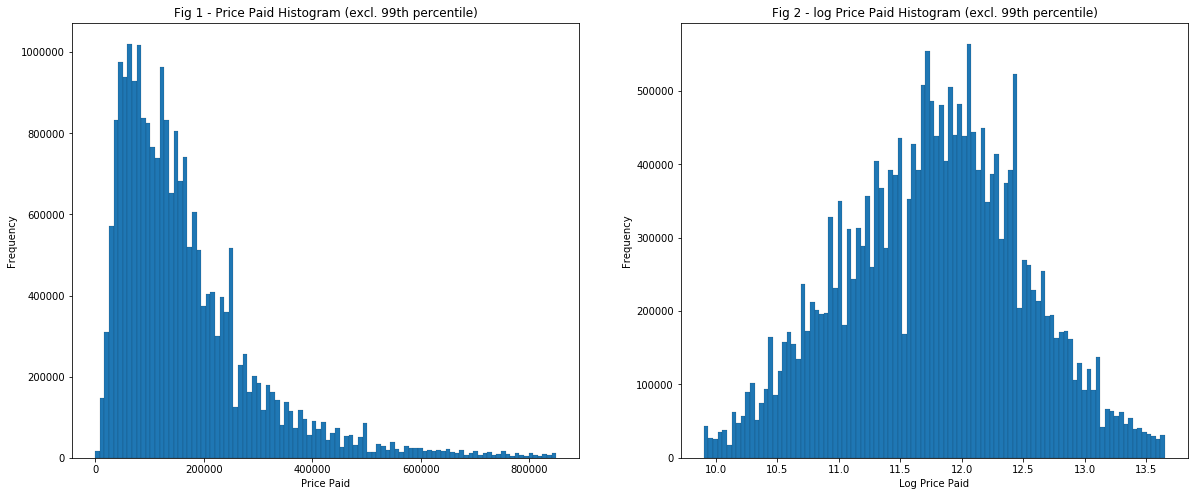

In [20]:
fig = plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
df[df['price']<=df.price.quantile(0.99)].price.plot.hist(bins=100, edgecolor='black', linewidth=0.1)
plt.title("Fig 1 - Price Paid Histogram (excl. 99th percentile)")
plt.xlabel("Price Paid")

plt.subplot(1,2,2)
df[(df['log_price']<=df.log_price.quantile(0.99)) & (df['log_price']>=df.log_price.quantile(0.01))].log_price.plot.hist(bins=100, edgecolor='black', linewidth=0.1)
plt.title("Fig 2 - log Price Paid Histogram (excl. 99th percentile)")
plt.xlabel("Log Price Paid")
plt.show()

Removing the top and bottom 5th percentiles as there are some real extreme prices which aren't representative of the tpyical property and probably can't be explained by the variables we have availabloe in our dataset.

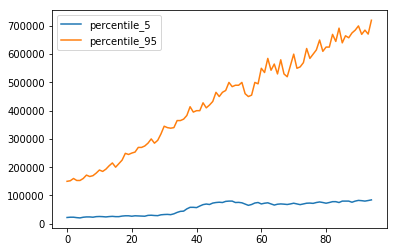

In [21]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

percentile_by_q = df.groupby(['Sale_quarter'])['price'].agg([percentile(5),percentile(95)]).reset_index()
df = df.merge(percentile_by_q, on=['Sale_quarter'], how='inner')
percentile_by_q.plot()
plt.show()

In [22]:
df = df[(df.price>df.percentile_5) & (df.price<df.percentile_95)]

In [24]:
#Deleting rows where the address is the same as the address, i.e. we only have property postcode
print(df.shape)
df2 = df[df.Address!=df.Postcode]
print(df2.shape)
df2.head()

(20693075, 18)
(20693041, 18)


,price,Property,Age,Duration,Sale_quarter,Postcode,Postcode_Dstr,Postcode_Area,Address,Easting,Northing,Output Area Classification Name,Region Name,Longitude,Latitude,log_price,percentile_5,percentile_95
0,89000,Terraced,Old,Freehold,2003Q4,LA95AP,LA9,LA,"''NUTSHELLCOTTAGE,72KIRKLANDLA95AP",351615,492059,Constrained city dwellers,North West,-2.745381,54.321804,11.396392,43687,365000.0
1,210000,Detached,Old,Freehold,2003Q4,NG139AD,NG13,NG,(BEVERLEY)DAWNSLANENG139AD,474099,340076,Suburbanites,East Midlands,-0.898523,52.952954,12.254863,43687,365000.0
2,142000,Terraced,Old,Freehold,2003Q4,CW39AS,CW3,CW,(SKERRATT)CHURCHVILLASTHEBUTTSCW39AS,375496,348461,Rural residents,West Midlands,-2.366847,53.032863,11.863582,43687,365000.0
3,239000,Detached,Old,Freehold,2003Q4,PE149PQ,PE14,PE,(WILSON)CHURCHROADPE149PQ,549123,296395,Rural residents,East of England,0.197652,52.544989,12.384219,43687,365000.0
4,117000,Flat,Old,Leasehold,2003Q4,SE135HU,SE13,SE,1-11FLAT2EASTDOWNPARKSE135HU,538773,175111,Ethnicity central,London,-0.003952,51.457974,11.669929,43687,365000.0


Next we convert all our covariates into dummy variable form. Luckily in pandas this is very easy! Then we calculate what our typical property is. This is acheived by taking the average value for each dummy variable in the data.

In [27]:
# Converting variables into dummy variables
df3 = df2[['Address','Postcode','Sale_quarter','log_price','Property','Age','Duration','Output Area Classification Name','Region Name']]
dummy_vars = ['Property','Age','Duration','Output Area Classification Name','Region Name']
df4 = pd.get_dummies(df3, columns=dummy_vars, prefix='dum')
df4.head()

,Address,Postcode,Sale_quarter,log_price,dum_Detached,dum_Flat,dum_Semi_Detached,dum_Terraced,dum_New,dum_Old,...,dum_(pseudo) Wales,dum_East Midlands,dum_East of England,dum_London,dum_North East,dum_North West,dum_South East,dum_South West,dum_West Midlands,dum_Yorkshire and The Humber
0,"''NUTSHELLCOTTAGE,72KIRKLANDLA95AP",LA95AP,2003Q4,11.396392,0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
1,(BEVERLEY)DAWNSLANENG139AD,NG139AD,2003Q4,12.254863,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
2,(SKERRATT)CHURCHVILLASTHEBUTTSCW39AS,CW39AS,2003Q4,11.863582,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
3,(WILSON)CHURCHROADPE149PQ,PE149PQ,2003Q4,12.384219,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
4,1-11FLAT2EASTDOWNPARKSE135HU,SE135HU,2003Q4,11.669929,0,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [32]:
from sklearn.model_selection import train_test_split

# Getting a list of properties
df_address = df4.groupby(['Address'])[['Address','log_price']].count()

train, test = train_test_split(df_address, test_size=0.25, random_state=4)

print("train shape:{}, test shape:{}".format(train.shape,test.shape))

train shape:(9098426, 2), test shape:(3032809, 2)


In [34]:
#Select the train address for regression
train_df = df4[df4.Address.isin(list(train.index))]
test_df = df4[df4.Address.isin(list(test.index))]

In [3]:
train_df.to_pickle(os.path.join(os.getcwd(),'0. Data/train_df.pkl'))
test_df.to_pickle(os.path.join(os.getcwd(),'0. Data/test_df.pkl'))

## 3.3 Fitting and applying the hedonic model
The "Valuation_Model" class below stores the regression coefficients for each quarter in a python dictionary. The class methods then allow for the operation to occur using there regression coefficients. Note a ridge linear regression has been used instead of the standard OLS. Sensible coefficients could not be obtained using a simple OLS, suggesting that some treatment (removal of outliers or correlated variables) may need to be performed. However for the sake of this notebook I shall ignore this.

In [4]:
from sklearn.linear_model import Ridge

''' Class provides list of methods to operate on a dictionary containing the 
hedonic regression models for each quarter in a defined period of time'''
class Hedonic_Model(object):

    def __init__(self):
        self.regr_dict = {}
        self.coef_name = None
        self.typical = pd.DataFrame()
        self.date_col = None
        self.fitted = False
        print("Hedonic Model initialised!")


    def date_list(self,df,date_col):
        return list(df['%s'%(date_col)].unique())
   

    ''' Performs a linear regression on every quarter within the dataframe X'''
    def fit(self,X,y,date_col):
        
        t0 = time.time()
        
        assert date_col in X.columns
        assert date_col in y.columns
        
        self.coef_name = list(X.columns)
        self.coef_name.remove(date_col)
        self.date_col = date_col
        
        if self.typical.empty:    
            self.typical = X.describe().iloc[1].to_frame().T

        fit_list = self.date_list(X,date_col)
        fit_list_size = len(fit_list)
        
        counter = 0
        
        print("Fitting model. {} quarters to fit to...".format(fit_list_size))
        for quarter in fit_list: 

            X_quarter = X[X[date_col]==quarter].drop('Sale_quarter', axis=1, inplace=False)
            y_quarter = y[y[date_col]==quarter].drop('Sale_quarter', axis=1, inplace=False)
            
            #Create new instance of ridge for each quarter
            reg = Ridge()
            reg.fit(X_quarter.values,y_quarter.values)
            
            self.regr_dict[quarter] = reg
            
            counter+=1
            
            t = time.time()
            
            print("Quarter {} fitted. {}/{} completed, Time Elapsed:{}"
                  .format(quarter, counter,fit_list_size,time.strftime('%H:%M:%S', time.gmtime(t-t0))), end="\r")
            
        self.fitted=True
     
        
    ''' Returns model prediction for a specific quarter '''
    def predict(self, df_array, quarter):
            
        df_array = df_array[model.coef_name]
        return self.regr_dict[quarter].predict(df_array).reshape(df_array.shape[0])
      
        
    ''' Generates an index for input typical property '''
    def gen_index(self, prop_def=None):

        if self.fitted==False:
            raise Exception('Index cannot be generated as the model has not been fitted.')
            
        index_dict = {}
        if prop_def==None:
            for quarter in self.regr_dict.keys():
                index_dict[quarter] = self.predict(self.typical,quarter)
        else:
            prop_def = prop_def[self.coef_name]
            for quarter in self.regr_dict.keys():
                index_dict[quarter] = self.predict(prop_def,quarter)
            
        index_df = pd.DataFrame(index_dict, index=['Value']).T
        index_df = np.exp(index_df).sort_index()
        index_df.loc[:,'Hedonic Index'] = index_df.loc[:,'Value']/index_df.loc[pd.Period('1995Q1',
                                                                                         freq='Q'),'Value']

        return index_df
            

Fitting our model to the data and comparing the resulting Hedonic index to the index derived from taking an average, the difference between the two indices is apparent in the 2004 to 2009 period.

In [11]:
train_df = pd.read_pickle(os.path.join(os.getcwd(),'0. Data/train_df.pkl'))
test_df = pd.read_pickle(os.path.join(os.getcwd(),'0. Data/test_df.pkl'))

In [12]:
test_df.head()

,Address,Sale_date,Postcode,Sale_quarter,log_price,dum_Detached,dum_Flat,dum_Semi_Detached,dum_Terraced,dum_New,...,dum_(pseudo) Wales,dum_East Midlands,dum_East of England,dum_London,dum_North East,dum_North West,dum_South East,dum_South West,dum_West Midlands,dum_Yorkshire and The Humber
0,"''NUTSHELLCOTTAGE,72KIRKLANDLA95AP",2003-10-10,LA95AP,2003Q4,11.396392,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
8,1-2EDENPLACENR301BQ,2003-11-06,NR301BQ,2003Q4,11.461632,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
11,1-2FLAT12QUEENSGATESW75EH,2003-12-19,SW75EH,2003Q4,12.736701,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
26,1-318LUDGATESQUAREEC4M7AS,2003-10-15,EC4M7AS,2003Q4,12.409013,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
27,1-3ASHLEIGHSTREETHX36QZ,2003-11-10,HX36QZ,2003Q4,10.818778,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [13]:
example_df = test_df[['Sale_quarter','log_price','dum_Detached','dum_Flat','dum_South East','dum_Semi_Detached','dum_(pseudo) Wales','dum_London']]
example_df.head()

,Sale_quarter,log_price,dum_Detached,dum_Flat,dum_South East,dum_Semi_Detached,dum_(pseudo) Wales,dum_London
0,2003Q4,11.396392,0,0,0,0,0,0
8,2003Q4,11.461632,0,0,0,0,0,0
11,2003Q4,12.736701,0,1,0,0,0,1
26,2003Q4,12.409013,0,1,0,0,0,1
27,2003Q4,10.818778,0,1,0,0,0,0


In [5]:
# Fitting the model
X_ = train_df.drop(['Postcode','log_price','Address'], axis=1)
y_ = train_df[['Sale_quarter','log_price']]

In [7]:
#reading in ons HPI
ONS_HPI = pd.read_csv(os.path.join(os.getcwd(),'0. Data/ONS_HPI.csv'))
#ONS_HPI['Sale_date'] = pd.to_datetime(ONS_HPI['Date'], format='%Y/%m/%d %H:%M')
ONS_HPI['Sale_date'] = pd.to_datetime(ONS_HPI['Date'], format='%d/%m/%Y')
ONS_HPI['Sale_quarter'] = ONS_HPI.Sale_date.dt.to_period('Q')
#ONS_HPI = ONS_HPI[['Sale_quarter']]
ONS_HPI['Halifax_index'] = ONS_HPI['Index']
ONS_HPI = ONS_HPI[['Sale_quarter','Halifax_index']]
ONS_HPI.set_index(['Sale_quarter'],inplace=True)
ONS_HPI['Halifax_index'] = ONS_HPI['Halifax_index']/29.07551622
ONS_HPI.head()

,Halifax_index
Sale_quarter,
1968Q2,0.064841
1968Q2,0.064841
1968Q2,0.064841
1968Q3,0.067039
1968Q3,0.067039


Hedonic Model initialised!


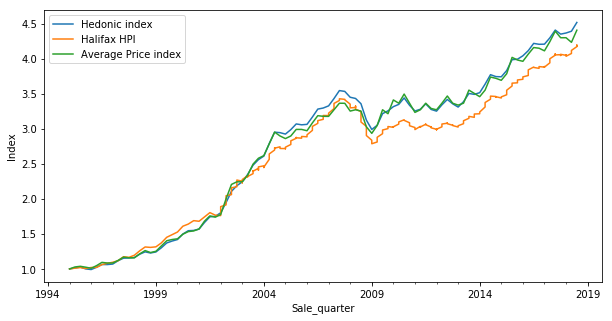

In [12]:
# Fitting the model
model = Hedonic_Model()
#model.fit(X_,y_,'Sale_quarter')

#Saving model object for use later
#pickle.dump(model, open( "hedonic_model.p", "wb" ) )
model = pickle.load( open( "hedonic_model.p", "rb" ) )

# Plotting the resulting HPI
index_df = model.gen_index()
index_df = index_df.merge(ONS_HPI,how='left',left_index=True,right_index=True)
index_df['Hedonic Index'].plot(figsize=(10,5))
index_df['Halifax_index'].plot()
median_price['Average Index'].plot()
plt.ylabel("Index")
plt.legend(labels=['Hedonic index','Halifax HPI','Average Price index'])
plt.savefig("Hedonic_plot.png")
plt.show()

In [9]:
index_df.head()

,Value,Hedonic Index,Halifax_index
1995Q1,54028.983457,1.000000,1.000000
1995Q1,54028.983457,1.000000,1.000000
1995Q1,54028.983457,1.000000,1.000000
1995Q2,54790.761349,1.014099,1.010763
1995Q2,54790.761349,1.014099,1.010763


# 4 Indices and Valuation Models
Within many banks the HPI will be used to value their portfolio according the simple calculation:

$$ value_{t} = \frac{index_{t} \times value_{t0}}{index_{t0}} $$

The downside to this methodology is that it's much more accurate to just apply the hedonic model to the data, rather than indirectly through an index. We can verify this by comparing valuation accuracy for properties which have sold mutliple times.

Three ways in which we can use our model to value a property:
- Method1: Generate a single index to value all properties
- Method2: Generate an index for every single combination possible using the hedonic regression, using each unique index to value
- Method3: Directly apply the hedonic model to value the properties
- Method4:Generate a single index using the average price paid

In [15]:
# Merging on the single series HPI
index_df = index_df.reset_index()
index_df.columns = ['Sale_quarter','Value','Single_index']
index_df = index_df[['Sale_quarter','Single_index']]
test_df_2 = test_df.merge(index_df, on=['Sale_quarter'], how='inner').sort_values(by=['Address','Sale_quarter'],ascending=True)

In [16]:
index_df.head()

,Sale_quarter,Single_index
0,1995Q1,1.000000
1,1995Q2,1.014099
2,1995Q3,1.025738
3,1995Q4,1.000195
4,1996Q1,0.991149


In [5]:
# Applying the hedonic model to all quarters
counter = 0
for quarter in pd.date_range(start='1/1/1995', periods=92, freq='Q').to_period('Q'):
    counter+=1
    df_quarter = test_df_2[test_df_2.Sale_quarter==quarter]
    test_df_2.loc[df_quarter.index,'pred_log_price'] = model.predict(df_quarter,quarter)
    print("Counter: %s" %(counter), end="\r")

'\ncounter = 0\nfor quarter in pd.date_range(start=\'1/1/1995\', periods=92, freq=\'Q\').to_period(\'Q\'):\n    counter+=1\n    df_quarter = test_df_2[test_df_2.Sale_quarter==quarter]\n    test_df_2.loc[df_quarter.index,\'pred_log_price\'] = model.predict(df_quarter,quarter)\n    print("Counter: %s" %(counter), end="\r")\n'

In [18]:
# Create a previous price, predicted price and index column
test_df_2.loc[:,'prev_log_price'] = test_df_2.log_price.shift()
test_df_2.loc[:,'prev_single_index'] = test_df_2.Single_index.shift()
test_df_2.loc[:,'prev_pred_log_price'] = test_df_2.pred_log_price.shift()
test_df_2.loc[:,'cumcount'] = test_df_2.groupby('Address').cumcount()

# Only keeping observations where a previous sale of the property has already occured
test_df_3 = test_df_2[test_df_2.cumcount>0]
test_df_3.loc[:,'price'] = np.exp(test_df_3.loc[:,'log_price'])
test_df_3.loc[:,'prev_price'] = np.exp(test_df_3.loc[:,'prev_log_price'])
test_df_3.loc[:,'Method1'] = test_df_3['prev_price']*test_df_3['Single_index']/test_df_3['prev_single_index']
test_df_3.loc[:,'Method2'] = test_df_3['prev_price']*np.exp(test_df_3['pred_log_price'] - test_df_3['prev_pred_log_price'])
test_df_3.loc[:,'Method3'] = np.exp(test_df_3['pred_log_price'])

c:\program files\python36\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
c:\program files\python36\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [18]:
#test_df_3.to_pickle(os.path.join(os.getcwd(),'0. Data/test_df_3.pkl'))
test_df_3 = pd.read_pickle(os.path.join(os.getcwd(),'0. Data/test_df_3.pkl'))

In [19]:
rmse_sale_quarter = pd.DataFrame()
rmse_cumcount = pd.DataFrame()
methods = ['Method1','Method2','Method3']
for method in methods:
    test_df_3.loc[:,"E_%s"%(method)] = test_df_3.price - test_df_3["%s"%(method)]
    test_df_3.loc[:,"_E_%s"%(method)] = test_df_3.loc[:,"E_%s"%(method)]/1000
    test_df_3.loc[:,"SE_%s"%(method)] = np.power(test_df_3.price - test_df_3["%s"%(method)],2)
    rmse_sale_quarter["MSE_%s"%(method)] = np.power(test_df_3.groupby(["Sale_quarter"])["SE_%s"%(method)].mean(),0.5)
    rmse_cumcount["MSE_%s"%(method)] = np.power(test_df_3.groupby(["cumcount"])["SE_%s"%(method)].mean(),0.5)

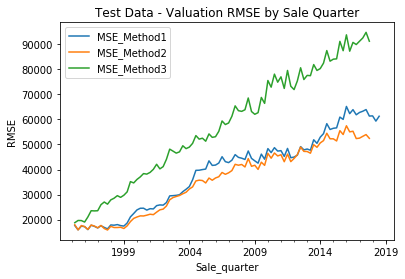

In [20]:
rmse_sale_quarter.plot()
plt.ylabel('RMSE')
plt.title("Test Data - Valuation RMSE by Sale Quarter")
plt.show()

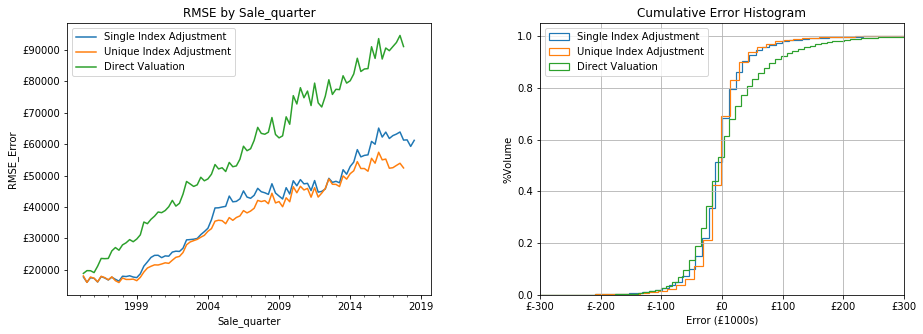

In [22]:
from matplotlib.ticker import FormatStrFormatter
fig, axs = plt.subplots(1,2,figsize=(15,5))

#Left plot
rmse_sale_quarter.plot(ax=axs[0])
ax=axs[0]
ax.set_title('RMSE by Sale_quarter')
ax.set_ylabel("RMSE_Error")
ax.yaxis.set_major_formatter(FormatStrFormatter('£%.0f'))
ax.legend(labels=['Single Index Adjustment','Unique Index Adjustment','Direct Valuation'])

#Right plot
#methods=['SE_Method1','SE_Method2','SE_Method3']
#for element in methods:
    
test_df_3.hist(cumulative=True,column='_E_Method1',ax=axs[1],bins=100,histtype='step', density=True, linewidth=1.2)
test_df_3.hist(cumulative=True,column='_E_Method2',ax=axs[1],bins=100,histtype='step', density=True, linewidth=1.2)
test_df_3.hist(cumulative=True,column='_E_Method3',ax=axs[1],bins=100,histtype='step', density=True, linewidth=1.2)
ax = axs[1]
ax.set_xlabel("Error (£1000s)")
ax.set_ylabel("%Volume")
ax.set_title("Cumulative Error Histogram")
ax.xaxis.set_major_formatter(FormatStrFormatter('£%.0f'))
#ax.yaxis.set_major_formatter(FormatStrFormatter("%.2f%%"))
plt.xlim(-300,300)
plt.legend(labels=['Single Index Adjustment','Unique Index Adjustment','Direct Valuation'], loc='upper left')
plt.savefig("RMSE_methods.png")
plt.show()

# 5. Geographic Clustering

The geographic regions used in the index have been defined according to the structure of regional governements and not the structure of the housing market. Could there be more optimal clustering?

In [15]:
train_df = pd.read_pickle(os.path.join(os.getcwd(),'0. Data/train_df.pkl'))
train_df.head()
#test_df = pd.read_pickle(os.path.join(os.getcwd(),'0. Data/test_df.pkl'))

,Address,Sale_date,Postcode,Sale_quarter,log_price,dum_Detached,dum_Flat,dum_Semi_Detached,dum_Terraced,dum_New,...,dum_(pseudo) Wales,dum_East Midlands,dum_East of England,dum_London,dum_North East,dum_North West,dum_South East,dum_South West,dum_West Midlands,dum_Yorkshire and The Humber
1,(BEVERLEY)DAWNSLANENG139AD,2003-12-19,NG139AD,2003Q4,12.254863,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,(SKERRATT)CHURCHVILLASTHEBUTTSCW39AS,2003-12-19,CW39AS,2003Q4,11.863582,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,(WILSON)CHURCHROADPE149PQ,2003-12-19,PE149PQ,2003Q4,12.384219,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1-11FLAT2EASTDOWNPARKSE135HU,2003-12-02,SE135HU,2003Q4,11.669929,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5,1-1AHUDROYDHD58RZ,2003-11-28,HD58RZ,2003Q4,11.001266,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [16]:
geo_data = train_df[['Sale_quarter','log_price','Postcode']].set_index('Sale_quarter')
geo_data.loc[:,'price']= np.exp(geo_data.log_price)
geo_data['Postcode'] = geo_data.Postcode.replace(" ","",regex=True).str.upper()
geo_data.loc[:,'Postcode_District'] = geo_data.Postcode.str[:-3]
geo_data = geo_data.drop(['log_price','Postcode'])

In [17]:
dist_median = geo_data.pivot_table(values='price', index='Sale_quarter', columns='Postcode_District')
dist_median.head()

Postcode_District,AL1,AL10,AL2,AL3,AL4,AL5,AL6,AL7,AL8,AL9,...,YO32,YO41,YO42,YO43,YO51,YO60,YO61,YO62,YO7,YO8
Sale_quarter,,,,,,,,,,,,,,,,,,,,,
1995Q1,78770.989691,62422.191176,81802.403846,87320.553571,83195.588235,82871.311475,100892.857143,62055.328767,92217.741935,81925.000000,...,66174.785714,64312.758621,68111.500000,52110.810811,60138.095238,69250.000000,72895.972222,72704.608696,70596.250000,55535.560345
1995Q2,79414.726562,62057.266667,81253.571429,82113.281250,84087.109375,88909.400000,102910.642857,67680.811765,83448.250000,75311.250000,...,68766.125000,73795.588235,63180.818182,59470.309524,59942.857143,62811.538462,75308.666667,60858.695652,63921.637931,55114.074074
1995Q3,79694.022556,63242.224719,81934.523810,88489.939759,82997.098592,101355.555556,112125.800000,69112.265957,84362.446809,87922.250000,...,72419.960526,73349.857143,68202.317073,62672.621622,63674.500000,78140.000000,78146.176471,77219.500000,71283.928571,55322.929293
1995Q4,76197.411765,57506.492308,84937.535211,89430.500000,92662.480769,91152.750000,105504.807692,66119.739130,95540.972222,92481.590909,...,66123.886792,70151.133333,69398.571429,60662.941176,84981.250000,73642.857143,72835.826087,81047.619048,67502.926829,56825.457746
1996Q1,81839.603960,51676.750000,74133.584906,87461.342857,84796.875000,90931.131148,88615.384615,65925.877193,85545.961538,80916.666667,...,62016.357143,67357.195122,57629.146341,59744.642857,60061.833333,70616.666667,81799.000000,76534.090909,67509.170732,55006.011236


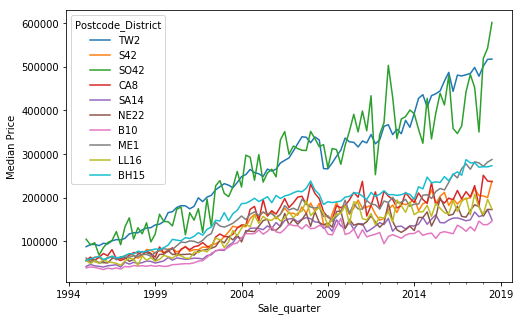

In [26]:
dist_median.sample(10,axis=1).plot(figsize=(8,5))
plt.ylabel("Median Price")
plt.savefig("Median_price.png",bbox_inches='tight',pad_inches=0.1)
plt.show()

In [6]:
dist_median2 = dist_median.interpolate(method='linear', limit=2, axis=1)
dist_median2.shape

(95, 2290)

In [7]:
missing = dist_median2.isna().sum()/dist_median2.isna().count()

In [8]:
missing = missing.to_frame()
missing.columns = ['perc_missing']

In [9]:
missing_lots = missing[missing.perc_missing>0.0]
missing_list = missing_lots.index

In [10]:
missing_list

Index(['EC1N', 'EC2M', 'EC2V', 'EC3R', 'EC3V', 'EC4A', 'EC4M', 'EC4N', 'EC4R',
       'EC4V', 'EC4Y', 'LL71', 'SW1H', 'TR23', 'TR24', 'TR25', 'W1D', 'W1F',
       'W1G', 'W1S', 'W1T', 'WC1E', 'WC2E', 'WC2H', 'WC2N', 'WC2R'],
      dtype='object', name='Postcode_District')

In [11]:
dist_median3 = dist_median2.drop(list(missing_list),axis=1)

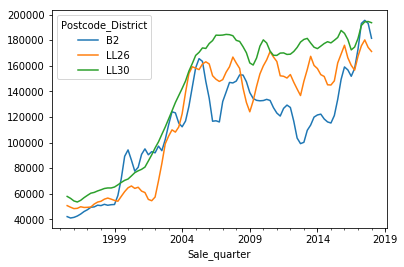

In [12]:
dist_median_smth = dist_median3.rolling(window=5,center=True, win_type='triang').mean().dropna(axis=0)
dist_median_smth[['B2','LL26','LL30']].plot()

In [28]:
#dist_median_smth.to_pickle(os.path.join(os.getcwd(),'0. Data/dist_median_smth.pkl'))
dist_median_smth = pd.read_pickle(os.path.join(os.getcwd(),'0. Data/dist_median_smth.pkl'))

In [29]:
dist_median_smth.head()

Postcode_District,AL1,AL10,AL2,AL3,AL4,AL5,AL6,AL7,AL8,AL9,...,YO32,YO41,YO42,YO43,YO51,YO60,YO61,YO62,YO7,YO8
Sale_quarter,,,,,,,,,,,,,,,,,,,,,
1995Q3,78990.770886,60328.125920,81569.085940,87037.697578,85609.215478,93110.378810,104746.282540,66991.011736,87647.720927,84688.233165,...,68359.005336,71068.107590,66167.375198,60015.535548,66785.738095,71910.606431,76158.054127,73856.647667,68311.815107,55598.824789
1995Q4,78746.510994,58893.131267,81764.184974,88266.129078,87232.647130,93918.480378,102132.697474,67047.211890,89950.679633,87157.650673,...,66876.868327,71169.232529,65613.287875,59988.975144,70023.565146,74583.715914,77654.861465,75870.414957,67867.556984,55751.868877
1996Q1,79540.514848,58631.065120,82908.384155,89691.837363,88124.380738,95189.292884,99729.313874,66576.107851,92481.716847,89115.624111,...,65677.881476,71259.268340,64814.788383,58787.159877,69707.481725,78501.005291,80388.756374,76402.187314,68082.513712,55610.906643
1996Q2,80824.735058,60496.280237,86153.317149,92628.889035,89438.098097,96696.887168,103128.555122,66628.321299,94970.991167,91315.013578,...,66117.294090,72845.988542,64930.579918,57877.183513,70815.382432,83327.807172,83107.527826,75248.672318,67580.029524,55804.650480
1996Q3,83723.535018,62978.989573,89068.344580,95844.990950,91176.538533,98578.532070,110902.273881,67373.806865,94732.871360,93101.356748,...,67912.754144,73522.350991,64564.369834,58630.292488,71189.313694,85627.307466,85070.170008,74284.998787,68128.300660,56311.053188


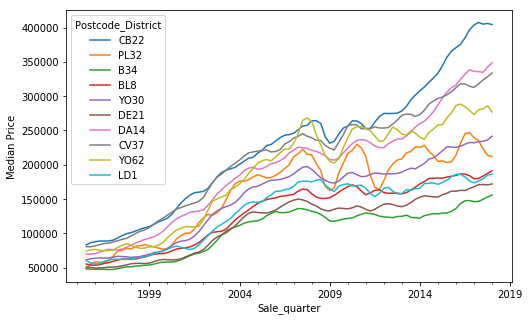

In [30]:
dist_median_smth.sample(10,axis=1).plot(figsize=(8,5))
plt.ylabel("Median Price")
plt.savefig("Median_price_smth.png",bbox_inches='tight',pad_inches=0.1)
plt.show()